May: Results of the original GYRE configuration **GYRE_Test**, second set of configurations **attempt1** where bathymetry and forcing are tested, third set of configurations **attempt2** where the forcing was changed, and instructions and log of progress.

The new gyre configuration **attempt1** uses the rectangular bathymetry created below. The results in **Test_A** reflect only the addition of bathy_meter.nc to the original GYRE configuration. **Test_B** follows with a change from 100 to 50 for the parameter nn_tau000 in namsbc_ana of the configuration namelist. **Test_C** attempts (unsuccessfully) to change the function used to calculate the wind speed in the files sbc_oce.F90 and sbcmod.F90. **Test_D** successfully changes the wind forcing by making changes in the sbc_gyre subroutine in the sbcana.F90 file.

In [35]:
import netCDF4 as nc
import numpy as np
from netCDF4 import Dataset
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import Image, display
%matplotlib inline

## 1. Original GYRE Configuration: Details

In [8]:
testT = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_T.nc')
testU = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_U.nc')
testV = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_V.nc')
testW = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_W.nc')
mmask = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/mesh_mask.nc')

In [9]:
lt = mmask.variables['glamt']; lu = mmask.variables['glamu']; lv = mmask.variables['glamv']; lf = mmask.variables['glamf']
pt = mmask.variables['gphit']; pu = mmask.variables['gphiu']; pv = mmask.variables['gphiv']; pf = mmask.variables['gphif']
t1 = mmask.variables['e1t']; u1 = mmask.variables['e1u']; v1 = mmask.variables['e1v']; f1 = mmask.variables['e1f']
t2 = mmask.variables['e2t']; u2 = mmask.variables['e2u']; v2 = mmask.variables['e2v']; f2 = mmask.variables['e2f']

In [6]:
tem = testT.variables['votemper']
sal = testT.variables['vosaline']
ssh = testT.variables['sossheig']
U = testU.variables['vozocrtx']
V = testV.variables['vomecrty']
W = testW.variables['vovecrtz']
lon = mmask.variables['nav_lon']
lat = mmask.variables['nav_lat']
dep = testT.variables['deptht']

GYRE structure (t, z, y, x) = (72, 31, 22, 32)

## Original GYRE Configuration: Results

The bathymetry used in the gyre run is rectangular with a 1-cell coastline going around the four sides. The rest of the bathymetry is flat at 30 m depth.

In [3]:
def draw(fig, t, axes, varb, ttls, lon, lat, dep_ind):
    for ax, var, ttl in zip(axes, varb, ttls):
        if ax == ax_ssh:
            cmax = var[:,1:21,1:31].max()
            cmin = var[:,1:21,1:31].min()
            cmap0 = cm.gist_ncar
            c = ax.pcolormesh(lon, lat, var[t,:,:], cmap=cmap0, vmin=cmin, vmax=cmax)
            #if t == 0:
            cbar = fig.colorbar(c, ax=ax)
            cbar.set_clim(cmin,cmax)
            #else:
                #pass
        else:
            if ax == ax_u or ax == ax_v or ax == ax_w:
                cmax = max(abs(var[:,0,:,:].max()), abs(var[:,0,:,:].min()))
                cmin = -1*cmax
                cmap0 = cm.seismic
            else:
                cmax = var[:,0,1:21,1:31].max()
                cmin = var[:,0,1:21,1:31].min()
                cmap0 = cm.gist_ncar
            c = ax.pcolormesh(lon, lat, var[t,dep_ind,:,:], cmap=cmap0, vmin=cmin, vmax=cmax)
            #if t == 0:
            cbar = fig.colorbar(c, ax=ax)
            cbar.set_clim(cmin,cmax)
            #else:
            #    pass
        ax.set_title(ttl)
        ax.set_ylabel('latitude')
        ax.set_xlabel('longitude')
        ax.grid()
    return ax

In [16]:
def draw_diff(fig, t, axes, varb, ttls, lon, lat, dep_ind):
    cmap0 = cm.RdYlBu_r
    for ax, var, ttl in zip(axes, varb, ttls):
        if ax == ax_ssh:
            end_point = max(abs(var[t, 1:21,1:31].max()), abs(var[t, 1:21,1:31].min()))
            cmax = end_point
            cmin = -1*end_point
            c = ax.pcolormesh(lon, lat, var[t,:,:], cmap=cmap0, vmin=cmin, vmax=cmax)
            #c = ax.pcolormesh(lon, lat, var[t,:,:], cmap=cmap0)
            fig.colorbar(c, ax=ax)
        else:
            end_point = max(abs(var[t,dep_ind, 1:21,1:31].max()), abs(var[t,dep_ind, 1:21,1:31].min()))
            cmax = end_point
            cmin = -1*end_point
            c = ax.pcolormesh(lon, lat, var[t,dep_ind,:,:], cmap=cmap0, vmin=cmin, vmax=cmax)
            #c = ax.pcolormesh(lon, lat, var[t,dep_ind,:,:], cmap=cmap0)
            fig.colorbar(c, ax=ax)
        ax.set_title(ttl)
        ax.set_ylabel('latitude')
        ax.set_xlabel('longitude')
    return fig

In [9]:
def animate_gyre(fig, axes, varb, ttls, dep_ind, frames, file_name):
    
    def init():
        pass

    def animate(t):
        draw(t, axes, varb, ttls, lon, lat, dep_ind)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=20, blit=False, repeat=False)
    mywriter = animation.FFMpegWriter()
    anim.save(file_name, writer=mywriter, fps=1, dpi=200, bitrate=1000000, codec="libx264")

## 2. New Bathymetry: Make Seafloor

Replace the flat bathymetry used in GYRE with the simple bathymetry below.

In [3]:
x = np.linspace(0,3,32)
y = np.linspace(0,2,22)
z = np.ones((len(y),len(x)))* 1000
for indx in np.arange(10,25):
    for indy in np.arange(5,15):
        z[indy, indx] = 2300
z[-1,:] = 0

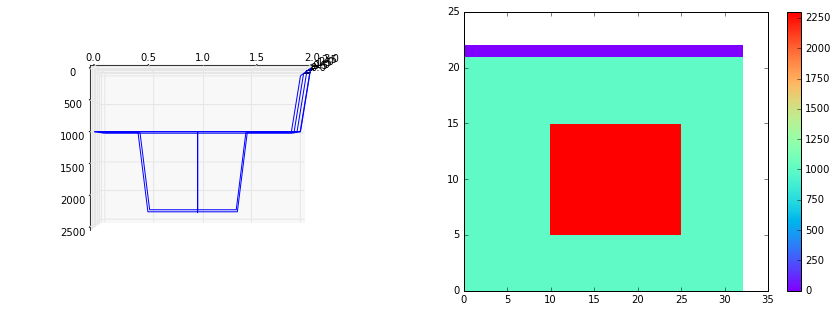

In [4]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_wireframe(X, Y, z, rstride=10, cstride=10)
ax.view_init(elev=0, azim=0)
ax.invert_zaxis()

ax = fig.add_subplot(1, 2, 2)
p = ax.pcolor(z, cmap=cm.rainbow)
fig.colorbar(p)

bathy files have **variables (dimensions)**: float64 nav_lon(y,x), float64 nav_lat(y,x), float64 Bathymetry(y,x)

http://unidata.github.io/netcdf4-python/

http://www.ceda.ac.uk/static/media/uploads/ncas-reading-2015/11_create_netcdf_python.pdf

The new bathymetry is inputted into gyre in NETCDF4 format. The file has the longitudes and latitudes originally used in gyre. The new bathymetry has the same size as the original, but it has a different depth profile.

In [10]:
bathy_rectangle = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/bathy_rectangle.nc')
bathy_rectangle

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Rectangular Bathymetry for Gyre Test Run
    author: Idalia A. Machuca
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/gyre_test.ipynb
    timeStamp: Wed May 25 21:54:12 2016
    dimensions(sizes): y(22), x(32)
    variables(dimensions): float64 nav_lon(y,x), float64 nav_lat(y,x), float64 Bathymetry(y,x)
    groups: 

## New Bathymetry: Make Coordinates

In [11]:
coords_rectangle = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/coords_rectangle.nc')
coords_rectangle

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Rectangular Coordinates for Gyre Test Run
    author: Idalia A. Machuca
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/gyre_test.ipynb
    dimensions(sizes): y(22), x(32), time(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float64 glamt(time,y,x), float64 glamu(time,y,x), float64 glamv(time,y,x), float64 glamf(time,y,x), float64 gphit(time,y,x), float64 gphiu(time,y,x), float64 gphiv(time,y,x), float64 gphif(time,y,x), float64 e1t(time,y,x), float64 e1u(time,y,x), float64 e1v(time,y,x), float64 e1f(time,y,x), float64 e2t(time,y,x), float64 e2u(time,y,x), float64 e2v(time,y,x), float64 e2f(time,y,x)
    groups: 

## <font color='DodgerBlue'>Notes:</font> Running New Configuration

**<font color='DodgerBlue'> ssh salish </font>**

Original: GYRE -- New: attempt1
___

### Make a new NEMO configuration
* /ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/
* **<font color='DodgerBlue'>./makenemo -r GYRE -n attempt1</font>**

This builds a new nemo configuration called attempt1 that is exactly the same as GYRE. "makenemo" is a file that is in CONFIG.
___

### Run the new configuration
* attempt1/EXP00
* **<font color='DodgerBlue'>nice ./opa & </font>**

This command runs the nemo model - the new configuation attempt1. "opa" is a file in EXP00, which was generated when the configuration was built. The ampersand runs nemo in the background so you can keep using the terminal.
___

### Change the new configuration
* Change EXP00/**namelist_cfg** >>> **namdom** >> **nn_bathy** to 1
* In EXP00: ln -s /ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/bathy_rectangle.nc **bathy_meter.nc**
* In CONFIG: **<font color='DodgerBlue'>./makenemo -n attempt1</font>**

We use "namelist_cfg" because "namelist_ref" is a symbolic link, so it was probably not being used. The building command is shorter because attempt1 is using itself as a reference since changes have been made to it. Get used to building new configurations until you get used to nemo.
___

### Run Mackenzie configuration

* ./makenemo -r GYRE -n gyre_mackenzie01
* **bathy_meter.nc** and **coordinates.nc**
* **nn_bathy** = 1 (0 for compute)
* **jphgr_msh** = 0 (5 for gyre)
* switch **ln_zco** and **ln_zps**
* modify **jpidta = jpiglo** and **jpjdta = jpjglo**
* ./makenemo -n attempt3
* nice ./opa
___

### Troubleshoot
* tail cfg.txt -------------------------------------- list of nemo configurations
* make changes to files in WORK
* tail time.step --------------------------------- tracks run time
* kill 8282 --------------------------------------- stops nemo when job number is 8282
* **<font color='DodgerBlue'>tail ocean.output</font>** ---------------------------- track model run errors
* emacs iodef.xml ---------------------------- make changes to frequency of model results
* Deleting a previously built configuration and attempting to rebuild it doesn't work.
* If a configuration is already built, it doesn't re-run (with "nice) if it has a bathymetry, but it can still re-run without it ---- solution below.
* The new configuration was initially built as Gyre0.
* ./makenemo -r attemp1 -n attempt2 works but remember to go on Salish
* re-building attempt1 as GYRE didn't overwrite the Test_A folder or switch nnbathy to 0.

### Troubleshoot Explained
### 1
* **nice ./opa &** runs nemo (didn't have to rebuild here)
* **tail ocean.output** at the bottom of this file is the number of errors that have occurred. Scan through the entire file to find **E R R O R**. In this case, there was one error that said that the file **bathy_level.nc** didn't exist. **bathy_level.nc** is not the same as **bathy_meter.nc**.
* **WORK/** is where the nemo code is stored. Don't change anything in here because it will affect the Salish Sea group if the changes are pushed.
* **grep 'bathy_level' *.F90** finds the words bathy_level in all files that contain .F90. This should tell us what bathy_level is because it's not in the manual. The result of the search is
        domzgr.F90:      !!      ntopo= 1 :   mbathy is read in 'bathy_level.nc' NetCDF file

* In routine **zgr_bat** of **domzgr.F90**, the code defines two conditions when **ntopo=1**:

        IF( ln_zco )   THEN                          ! zco : read level bathymetry 
                    CALL iom_open ( 'bathy_level.nc', inum )

        IF( ln_zps .OR. ln_sco )   THEN              ! zps or sco : read meter bathymetry
                    CALL iom_open ( 'bathy_meter.nc', inum )

* In **namlist_cfg** there is a section **namzgr** that defines details about the vertical coordinates, in particular **ln_zco** and **ln_zps**. I specified the following:

       ln_zco      = .false.    !  z-coordinate - full    steps   (T/F)      ("key_zco" may also be defined)
       ln_zps      = .true.   !  z-coordinate - partial steps   (T/F)

    Originally, the true and false were the other way around, but we want to use partial steps so that nemo looks for **bathy_meter.nc**. According to the nemo manual (pg. 58), there should be another option **ln_sco** for an s-coordinate, but that was not included in the namelist I'm using.


* Note: In **attempt1/cpp_attempt1.fcm**, there is a list of keys that are used to unlock modules in nemo. Since no key was specified for **ln_zps**, we don't need to add any to the file.

### 2

**jphgr_msh** !: type of horizontal mesh
* = 0 curvilinear coordinate on the sphere read in coordinate.nc file
* = 1 geographical mesh on the sphere with regular grid-spacing

## New Bathymetry: Run Model

In [12]:
gridT1A = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_T.nc')
gridU1A = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_U.nc')
gridV1A = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_V.nc')
gridW1A = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_W.nc')
mask1A = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/mesh_mask.nc')

In [13]:
tem1A = gridT1A.variables['votemper']
sal1A = gridT1A.variables['vosaline']
ssh1A = gridT1A.variables['sossheig']
U1A = gridU1A.variables['vozocrtx']
V1A = gridV1A.variables['vomecrty']
W1A = gridW1A.variables['vovecrtz']
lon1A = mask1A.variables['nav_lon']
lat1A = mask1A.variables['nav_lat']
mbathy1A = mask1A.variables['mbathy']
tbathy1A = gridT1A.variables['deptht']

In [14]:
d_tem1A = np.subtract(tem1A,tem)
d_sal1A = np.subtract(sal1A,sal)
d_ssh1A = np.subtract(ssh1A,ssh)
d_U1A = np.subtract(np.abs(U1A),np.abs(U))
d_V1A = np.subtract(np.abs(V1A),np.abs(V))
d_W1A = np.subtract(np.abs(W1A),np.abs(W))

**Summary**: This configuration uses bathy_meter.nc alone and partial steps.

**Difference between the original, flat and new, rectangular hole bathymetry.** (Original vs A)

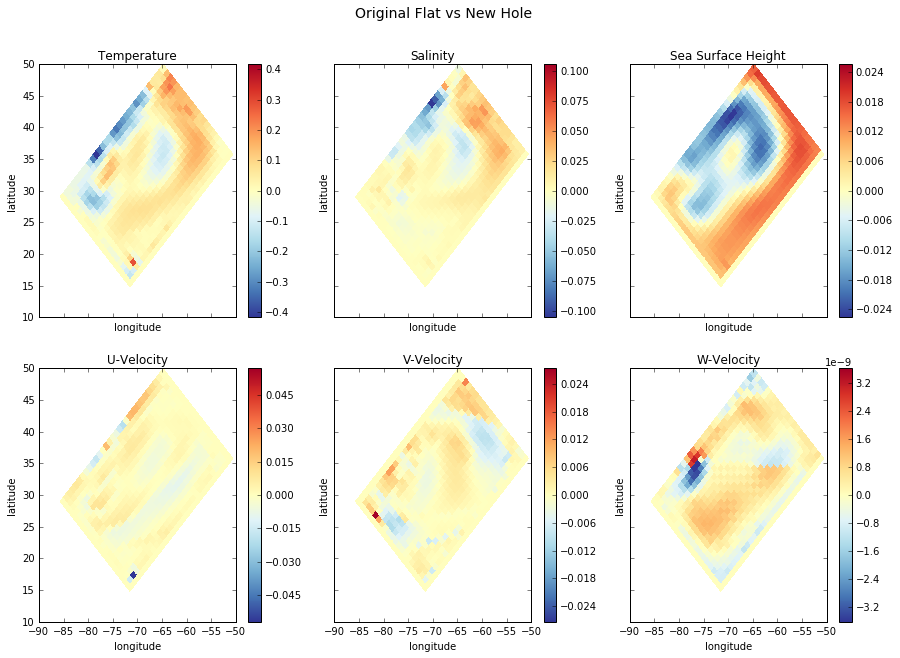

In [19]:
fig, [(ax1, ax2, ax_ssh),(ax_u, ax_v, ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [d_tem1A, d_sal1A, d_ssh1A, d_U1A, d_V1A, d_W1A]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t_plot = 55

fig = draw_diff(fig, t_plot, axes, varb, ttls, lon, lat, dep_ind)
fig.suptitle('Original Flat vs New Hole', fontsize=14)

## New Bathymetry: Weird Mesh Mask

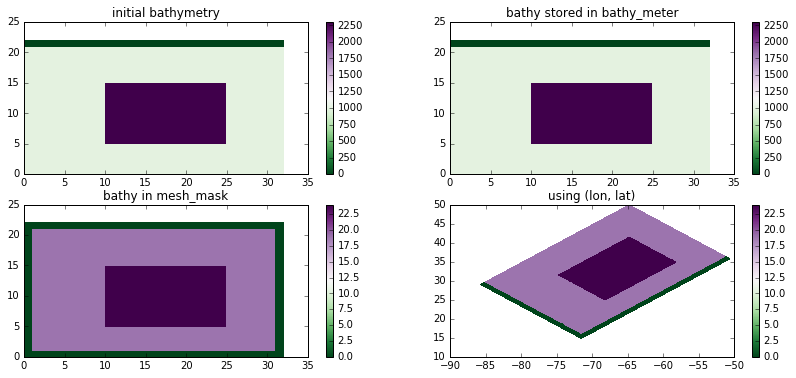

In [26]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2,figsize=(14,6))

axes = [ax1, ax2, ax3, ax4]
plot_values = [z[:], bat_test[:], mbathy1A[0,:,:], mbathy1A[0,:,:]]
ttls = ['initial bathymetry', 'bathy stored in bathy_meter', 'bathy in mesh_mask', 'using (lon, lat)']

for axs, pv, ttl in zip(axes, plot_values, ttls):
    if axs == ax4:
        axs.pcolor(lon, lat, mbathy1A[0,:,:], cmap=cm.PRGn_r)
    else:
        p = axs.pcolor(pv, cmap=cm.PRGn_r)
    fig.colorbar(p, ax=axs)
    axs.set_title(ttl)

(coast, flat plain, rectangular hole)
* ** bathy_meter.nc (z, bat_test)**: 0, 1000, 2300 (one wall)
* ** mesh_mask.nc (mbathy)**: 0, 19, 24 (four walls)
* ** grid_t.nc (deptht)**: grid depths (from 4.9 m to 4451 m )

**Changing wind forcing for later**
* namelist_cfg has a surface section, but it says that it uses a constant forcing so it's probably getting it from somewhere else
* look into WORK/par_oce but there should be a par_gyre
* copy par_oce into MY_SRC
* It'll use WORK and MY_SRC
* <font color='blue'>Don't change anything in WORK or NEMOGCM/NEMO </font>
* More surface code /NEMOGCM/NEMO/OPA_SRC/SBC

## 3. New Forcing: "Test B" - nn_tau000

* **/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/namelist_cfg**

    !-----------------------------------------------------------------------                                        
    &namsbc_ana    !   analytical surface boundary condition                                                        
    !-----------------------------------------------------------------------                                        
       nn_tau000   =   100     !  gently increase the stress over the first ntau_rst time-steps                     
       rn_utau0    =   0.1e0   !  uniform value for the i-stress 
       

**Test_B**: Changing ``nn_tau000`` in ``namelist_cfg`` from 100 to 50 <font color='OrangeRed'> didn't change the results </font>. Maybe there is a difference somewhere around the ``ntau_rst``th time-step, but I didn't change that - but I also don't know where it's defined.

In [20]:
def find_difference(grid_T, grid_U, grid_V, grid_W, ref_varb):
    new_temp = grid_T.variables['votemper']
    new_sal = grid_T.variables['vosaline']
    new_ssh = grid_T.variables['sossheig']
    new_U = grid_U.variables['vozocrtx']
    new_V = grid_V.variables['vomecrty']
    new_W = grid_W.variables['vovecrtz']
    
    d_tem = np.subtract(new_temp,ref_varb[0])
    d_sal = np.subtract(new_sal,ref_varb[1])
    d_ssh = np.subtract(new_ssh,ref_varb[2])
    d_U = np.subtract(np.abs(new_U),np.abs(ref_varb[3]))
    d_V = np.subtract(np.abs(new_V),np.abs(ref_varb[4]))
    d_W = np.subtract(np.abs(new_W),np.abs(ref_varb[5]))
    
    return new_temp, new_sal, new_ssh, new_U, new_V, new_W, d_tem, d_sal, d_ssh, d_U, d_V, d_W

In [23]:
gridT1B = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_T.nc')
gridU1B = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_U.nc')
gridV1B = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_V.nc')
gridW1B = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_W.nc')
mask1B = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/mesh_mask.nc')

In [24]:
ref_varb = [tem1A, sal1A, ssh1A, U1A, V1A, W1A]
tem1B, sal1B, ssh1B, U1B, V1B, W1B, \
        d_tem1B, d_sal1B, d_ssh1B, d_U1B, d_V1B, d_W1B = find_difference(gridT1B, gridU1B, gridV1B, gridW1B, ref_varb)

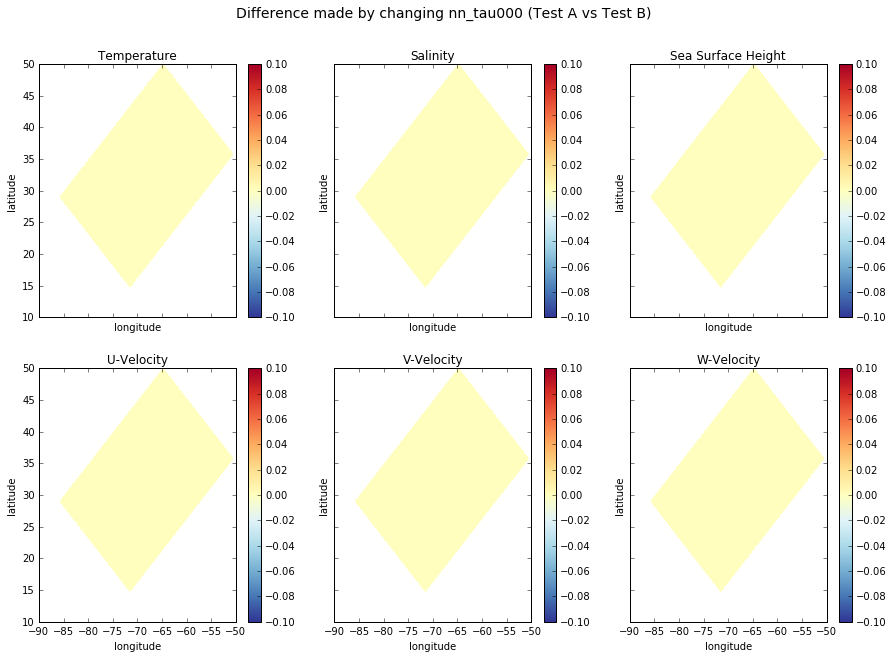

In [26]:
fig, [(ax1, ax2, ax_ssh),(ax_u, ax_v, ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [d_tem1B, d_sal1B, d_ssh1B, d_U1B, d_V1B, d_W1B]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t_plot = 55

fig = draw_diff(fig, t_plot, axes, varb, ttls, lon, lat, dep_ind)
fig.suptitle('Difference made by changing nn_tau000 (Test A vs Test B)', fontsize=14)

## New Forcing: "Test C" - sbc_oce.F90

* **/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/WORK/par_oce.F90** is a symbolic file to **/ocean/imachuca/NEMO-3.6-code/NEMOGCM/NEMO/OPA_SRC/par_oce.F90**. I copied this file to **/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/MY_SRC**. It sets the ocean parameters. I can't find any reference to forcing here.

* **/ocean/imachuca/NEMO-3.6-code/NEMOGCM/NEMO/OPA_SRC/SBC/sbc_oce.F90**

    SUBROUTINE sbc_tau2wnd
          !!---------------------------------------------------------------------
          !!                    ***  ROUTINE sbc_tau2wnd  ***
          !!                   
          !! ** Purpose : Estimation of wind speed as a function of wind stress   
          !!
          !! ** Method  : |tau|=rhoa*Cd*|U|^2
          !!---------------------------------------------------------------------

    !CDIR NOVERRCHK
             DO ji = fs_2, fs_jpim1   ! vect. opt.
                ztx = utau(ji-1,jj  ) + utau(ji,jj) 
                zty = vtau(ji  ,jj-1) + vtau(ji,jj) 
                ztau = SQRT( ztx * ztx + zty * zty )
                wndm(ji,jj) = SQRT ( ztau * zcoef ) * tmask(ji,jj,1)
             END DO
          END DO
          CALL lbc_lnk( wndm(:,:) , 'T', 1. )
          !
       END SUBROUTINE sbc_tau2wnd
* I removed the **SQRT** from the calculation for wndm and re-ran the configuration:

        !! wndm is used onmpute surface gases exchanges in ice-free ocean or leads
        REAL(wp), PUBLIC, ALLOCATABLE, SAVE, DIMENSION(:,:) ::   wndm  
        !: wind speed module at T-point (=|U10m-Uoce|)  [m/s]
        
* I also returned nn_tau000 to 100 from **Test_B**
        
* Results show <font color='OrangeRed'>no change</font> compared to the **Test_A**

In [27]:
gridT1C = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_C/GYRE_5d_00010101_00011230_grid_T.nc')
gridU1C = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_C/GYRE_5d_00010101_00011230_grid_U.nc')
gridV1C = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_C/GYRE_5d_00010101_00011230_grid_V.nc')
gridW1C = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_C/GYRE_5d_00010101_00011230_grid_W.nc')
mask1C = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_C/mesh_mask.nc')

In [28]:
ref_varb = [tem1A, sal1A, ssh1A, U1A, V1A, W1A]
tem1C, sal1C, ssh1C, U1C, V1C, W1C, \
        d_tem1C, d_sal1C, d_ssh1C, d_U1C, d_V1C, d_W1C = find_difference(gridT1C, gridU1C, gridV1C, gridW1C, ref_varb)

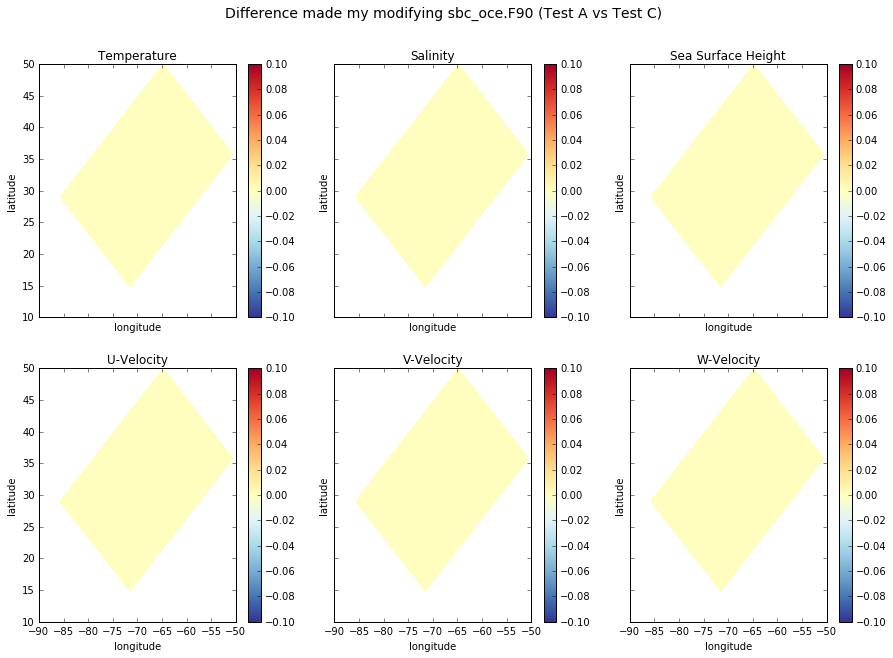

In [30]:
fig, [(ax1, ax2, ax_ssh),(ax_u, ax_v, ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [d_tem1C, d_sal1C, d_ssh1C, d_U1C, d_V1C, d_W1C]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t_plot = 55

fig = draw_diff(fig, t_plot, axes, varb, ttls, lon, lat, dep_ind)
fig.suptitle('Difference made my modifying sbc_oce.F90 (Test A vs Test C)', fontsize=14)

* **/ocean/imachuca/NEMO-3.6-code/NEMOGCM/NEMO/OPA_SRC/SBC/sbcmod.F90**
******
      !! Surface module :  provide to the ocean its surface boundary condition
******       
      !!----------------------------------------------------------------------  
      !!                    ***  ROUTINE sbc_init ***
      !! ** Purpose :   Initialisation of the ocean surface boundary computation
      !! ** Method  :   Read the namsbc namelist and set derived parameters
      !!                Call init routines for all other SBC modules that have one
      !!----------------------------------------------------------------------  
         IF( cp_cfg == 'gyre' ) THEN            ! GYRE configuration
          ln_ana      = .TRUE.   
          nn_ice      =   0
         ENDIF
      
      !!----------------------------------------------------------------------
      !!                    ***  ROUTINE sbc  ***         
      !! ** Purpose :   provide at each time-step the ocean surface boundary
      !!                condition (momentum, heat and freshwater fluxes)
      !!----------------------------------------------------------------------
lots of IF statements here

* What happens if I change namsbc's **ln_ana** to false? No errors and <font color='OrangeRed'>no change </font> compared to **Test_A**.
* Revisiting **wndm** in sbc_oce.F90 and making it just wndm(ji,jj) = zcoef * tmask(ji,jj,1) has <font color='OrangeRed'>no effect </font> on final results. 

*Five different ways to provide the first six fields to the ocean are available
which are controlled by namelist namsbc variables : an analytical formulation
(ln ana = true), a flux formulation (ln flx = true), a bulk formulae formulation
(CORE (ln blk core = true), CLIO (ln blk clio = true) or MFS1 (ln blk mfs = true)
bulk formulae) and a coupled or mixed forced/coupled formulation (exchanges
with a atmospheric model via the OASIS coupler) (ln cpl or ln mixcpl = true).*


*When the fields are supplied from data files (flux and
bulk formulations), the input fields need not be supplied on the model grid. Instead
a file of coordinates and weights can be supplied which maps the data from the
supplied grid to the model points (so called ”Interpolation on the Fly”, see x7.2.2).*

*The ocean model provides, at each time step, to the surface module (sbcmod.
F90) the surface currents, temperature and salinity. These variables are averaged
over nn fsbc time-step (7.1), and it is these averaged fields which are used to
computes the surface fluxes at a frequency of nn fsbc time-step.*

*sbcmod.F90 : This has been cut down and now only calculates surface forcing
and the ice model required. New surface modules that can function
when only the surface level of the ocean state is defined can also be added
(e.g. icebergs).*

## New Forcing: "Test D" - sbcana.F90

*<font color='DodgerBlue'> The analytical formulation of the surface boundary condition is the default
scheme. In this case, all the six fluxes needed by the ocean are assumed to be
uniform in space. They take constant values given in the namelist namsbc ana by
the variables rn utau0, rn vtau0, rn qns0, rn qsr0, and rn emp0 (emp = empS).
The runoff is set to zero. In addition, the wind is allowed to reach its nominal value
within a given number of time steps (nn tau000).
If a user wants to apply a different analytical forcing, the sbcana.F90 module
can be modified to use another scheme. As an example, the sbc ana gyre.F90 routine
provides the analytical forcing for the GYRE configuration (see GYRE configuration
manual, in preparation). </font>*

**/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/MY_SRC/sbcana.F90** copied from the corresponding **WORK** directory.

***
        *** MODULE sbcana ***                                                             
       !! Ocean forcing:  analytical momentum, heat and freshwater forcings
***
    nn_tau000  ! nb of time-step during which the surface stress increase from 0 to its nominal value (gently increase the stress over the first ntau_rst time-steps)
    rn_utau0   ! constant wind stress value in i-direction
    rn_vtau0   ! constant wind stress value in j-direction
    rn_qns0    ! non solar heat flux (uniform value for the total heat flux)
    rn_qsr0    !     solar heat flux
    rn_emp0    ! net freshwater flux
    
* 
      !!---------------------------------------------------------------------
      !!                    ***  ROUTINE sbc_ana ***
      !!              
      !! ** Purpose :   provide at each time-step the ocean surface boundary
      !!              condition, i.e. the momentum, heat and freshwater fluxes.
      !!
      !! ** Method  :   Constant and uniform surface forcing specified from
      !!              namsbc_ana namelist parameters. All the fluxes are time
      !!              independant except the stresses which increase from zero
      !!              during the first nn_tau000 time-step 
      !!
      !! ** Action  : - set the ocean surface boundary condition, i.e.  
      !!                   utau, vtau, taum, wndm, qns, qsr, emp, sfx
      !!----------------------------------------------------------------------
* 
      !!---------------------------------------------------------------------
      !!                    ***  ROUTINE sbc_gyre ***
      !!              
      !! ** Purpose :   provide at each time-step the GYRE surface boundary
      !!              condition, i.e. the momentum, heat and freshwater fluxes.
      !!
      !! ** Method  :   analytical seasonal cycle for GYRE configuration.
      !!                CAUTION : never mask the surface stress field !
      !!
      !! ** Action  : - set the ocean surface boundary condition, i.e.   
      !!                   utau, vtau, taum, wndm, qns, qsr, emp, sfx
      !!
      !! Reference : Hazeleger, W., and S. Drijfhout, JPO, 30, 677-695, 2000.
      !!----------------------------------------------------------------------
      
* Test sbc_gyre using the original GYRE configuration called **GYRE_Test**
* opa points to -> /ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE/BLD/bin/nemo.exe but the BLD directory doesn't exist so GYRE_Test can't be run. 
* Instead, change **sbcana** in attempt1. Note: the SQRT had already been removed from GYRE_Test's MY_SRC file. I'll try the same for attempt1.
* sbc_ana: <font color='OrangeRed'>no result</font>
* sbc_gyre: <font color='OrangeRed'>no result</font>                                 
* **<font color='OrangeRed'>WORKING!</font>**
*grep sbc_ana ocean.output* gives nothing, but *grep sbc_gyre ocean.output* gives **sbc_gyre : analytical surface fluxes for GYRE configuration** which means that it's using sbc_gyre not sbc_ana.


         SUBROUTINE sbc_gyre( kt )
         
      ! mean intensity at 0.105 ; srqt(2) because projected with 45deg angle
      ztau = 5 / SQRT( 2. )
      ! seasonal oscillation intensity
      ztau_sais = 5
      
Initially, the intensity was changed from 0.105 to 150, but this produced an error that a velocity U could not be higher than 20. I'm guessing that the high intensity winds produced unrealistically high velocities, giving this error. So, ztau and ztau_sais were changed to 5 instead - no error.
* **<font color='DodgerBlue'>./makenemo -n attempt1</font>** in /ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG you need to rebuild the configuration because you have changed the root code. Then, nice ./opa.

In [31]:
gridT1D = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_D/GYRE_5d_00010101_00011230_grid_T.nc')
gridU1D = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_D/GYRE_5d_00010101_00011230_grid_U.nc')
gridV1D = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_D/GYRE_5d_00010101_00011230_grid_V.nc')
gridW1D = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_D/GYRE_5d_00010101_00011230_grid_W.nc')

In [32]:
ref_varb = [tem1A, sal1A, ssh1A, U1A, V1A, W1A]

tem1D, sal1D, ssh1D, U1D, V1D, W1D, \
        d_tem1D, d_sal1D, d_ssh1D, d_U1D, d_V1D, d_W1D = find_difference(gridT1D, gridU1D, gridV1D, gridW1D, ref_varb)

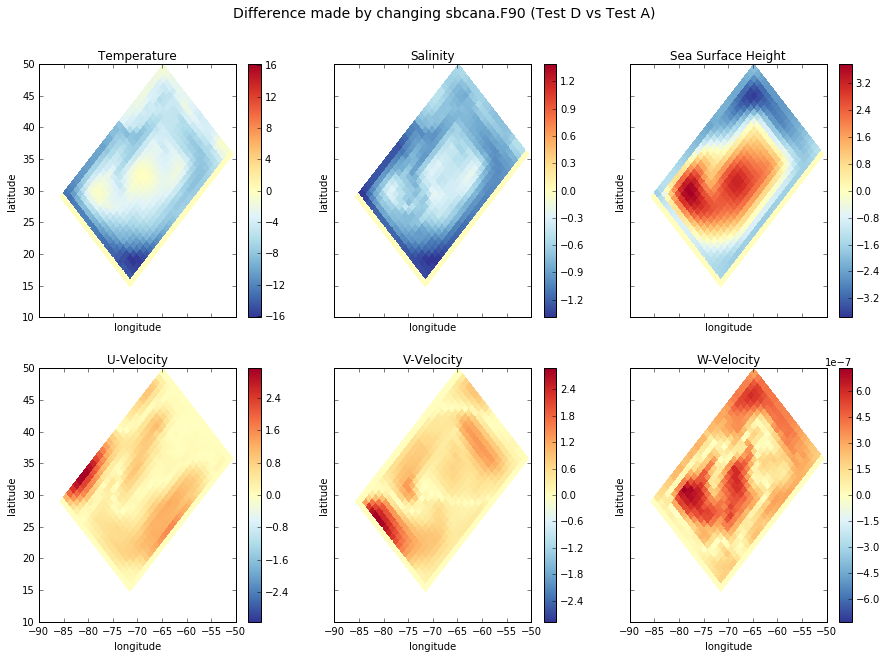

In [33]:
fig, [(ax1, ax2, ax_ssh),(ax_u, ax_v, ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [d_tem1D, d_sal1D, d_ssh1D, d_U1D, d_V1D, d_W1D]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t_plot = 55

fig = draw_diff(fig, t_plot, axes, varb, ttls, lon, lat, dep_ind)
fig.suptitle('Difference made by changing sbcana.F90 (Test D vs Test A)', fontsize=14)

* <font color='DodgerBlue'> Previously, sbcana.F90 was copied to /MY_SRC from /WORK and attempt1 was rebuilt. Consequently, the sbcana.F90 symlink in /WORK now refers to the file in /MY_SRC. To retrieve the original, simply rebuild attempt1. </font>

* A closer look at /ocean/imachuca/NEMO-3.6-code/NEMOGCM/NEMO/OPA_SRC/SBC/sbcana.F90
* I will rebulid attempt2 to change the wind forcing of the flat bathymetry instead of changing it for the rectangular hole. Meanwhile I restored the original sbcana.F90 in attempt1 meaning that the forcing that created Test_D is gone. I checked the results of attempt2 and confirmed that the results are the same as those for GYRE_Test.

The GYRE configuration has been built to simulate the seasonal cycle of a double-gyre box model. The circulation
is forced by analytical profiles of wind and buoyancy fluxes.

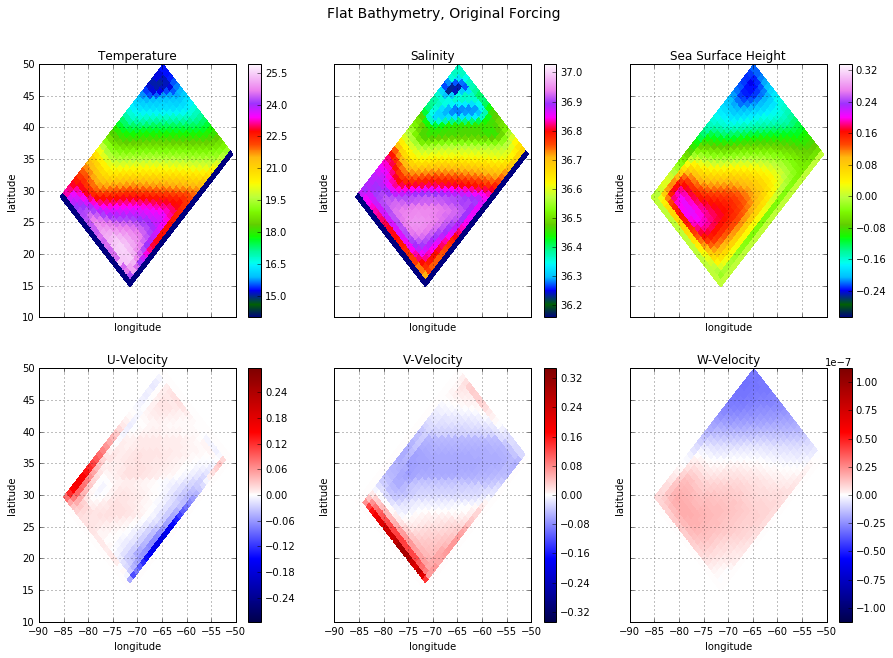

In [37]:
fig, [(ax1,ax2,ax_ssh),(ax_u,ax_v,ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [tem, sal, ssh, U, V, W]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t = 36

fig = draw(fig, t, axes, varb, ttls, lon, lat, dep_ind)
plt.suptitle('Flat Bathymetry, Original Forcing', fontsize=14)

In [2]:
gridT2 = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt2/EXP00/GYRE_5d_00010101_00011230_grid_T.nc')
gridU2 = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt2/EXP00/GYRE_5d_00010101_00011230_grid_U.nc')
gridV2 = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt2/EXP00/GYRE_5d_00010101_00011230_grid_V.nc')
gridW2 = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt2/EXP00/GYRE_5d_00010101_00011230_grid_W.nc')
tem2 = gridT2.variables['votemper']
sal2 = gridT2.variables['vosaline']
ssh2 = gridT2.variables['sossheig']
U2 = gridU2.variables['vozocrtx']
V2 = gridV2.variables['vomecrty']
W2 = gridW2.variables['vovecrtz']
lon2 = gridT2.variables['nav_lon']
lat2 = gridT2.variables['nav_lat']

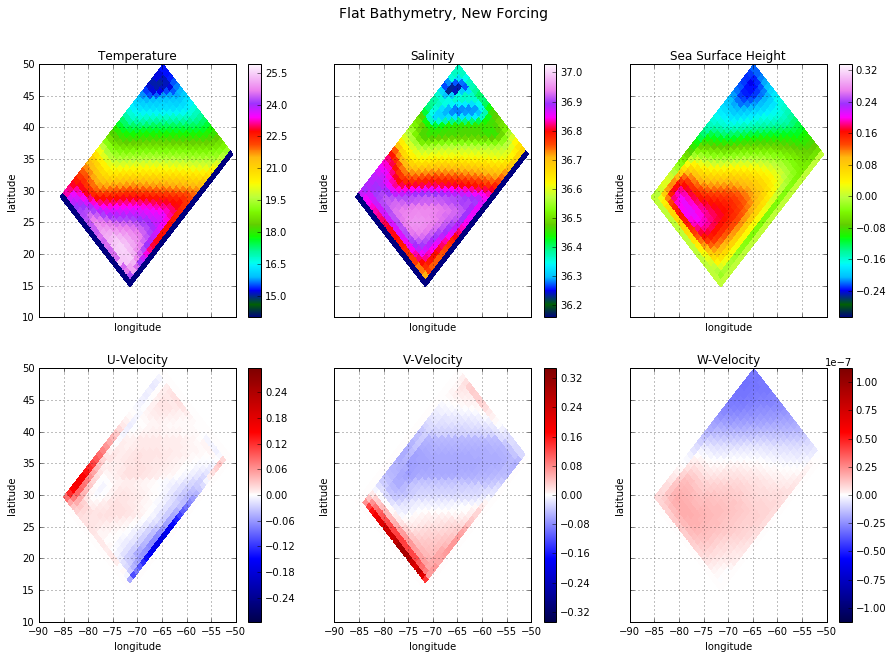

In [7]:
fig, [(ax1,ax2,ax_ssh),(ax_u,ax_v,ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [tem2, sal2, ssh2, U2, V2, W2]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t = 36

fig = draw(fig, t, axes, varb, ttls, lon, lat, dep_ind)
plt.suptitle('Flat Bathymetry, New Forcing', fontsize=14)

## 4. Mackenzie Canyon


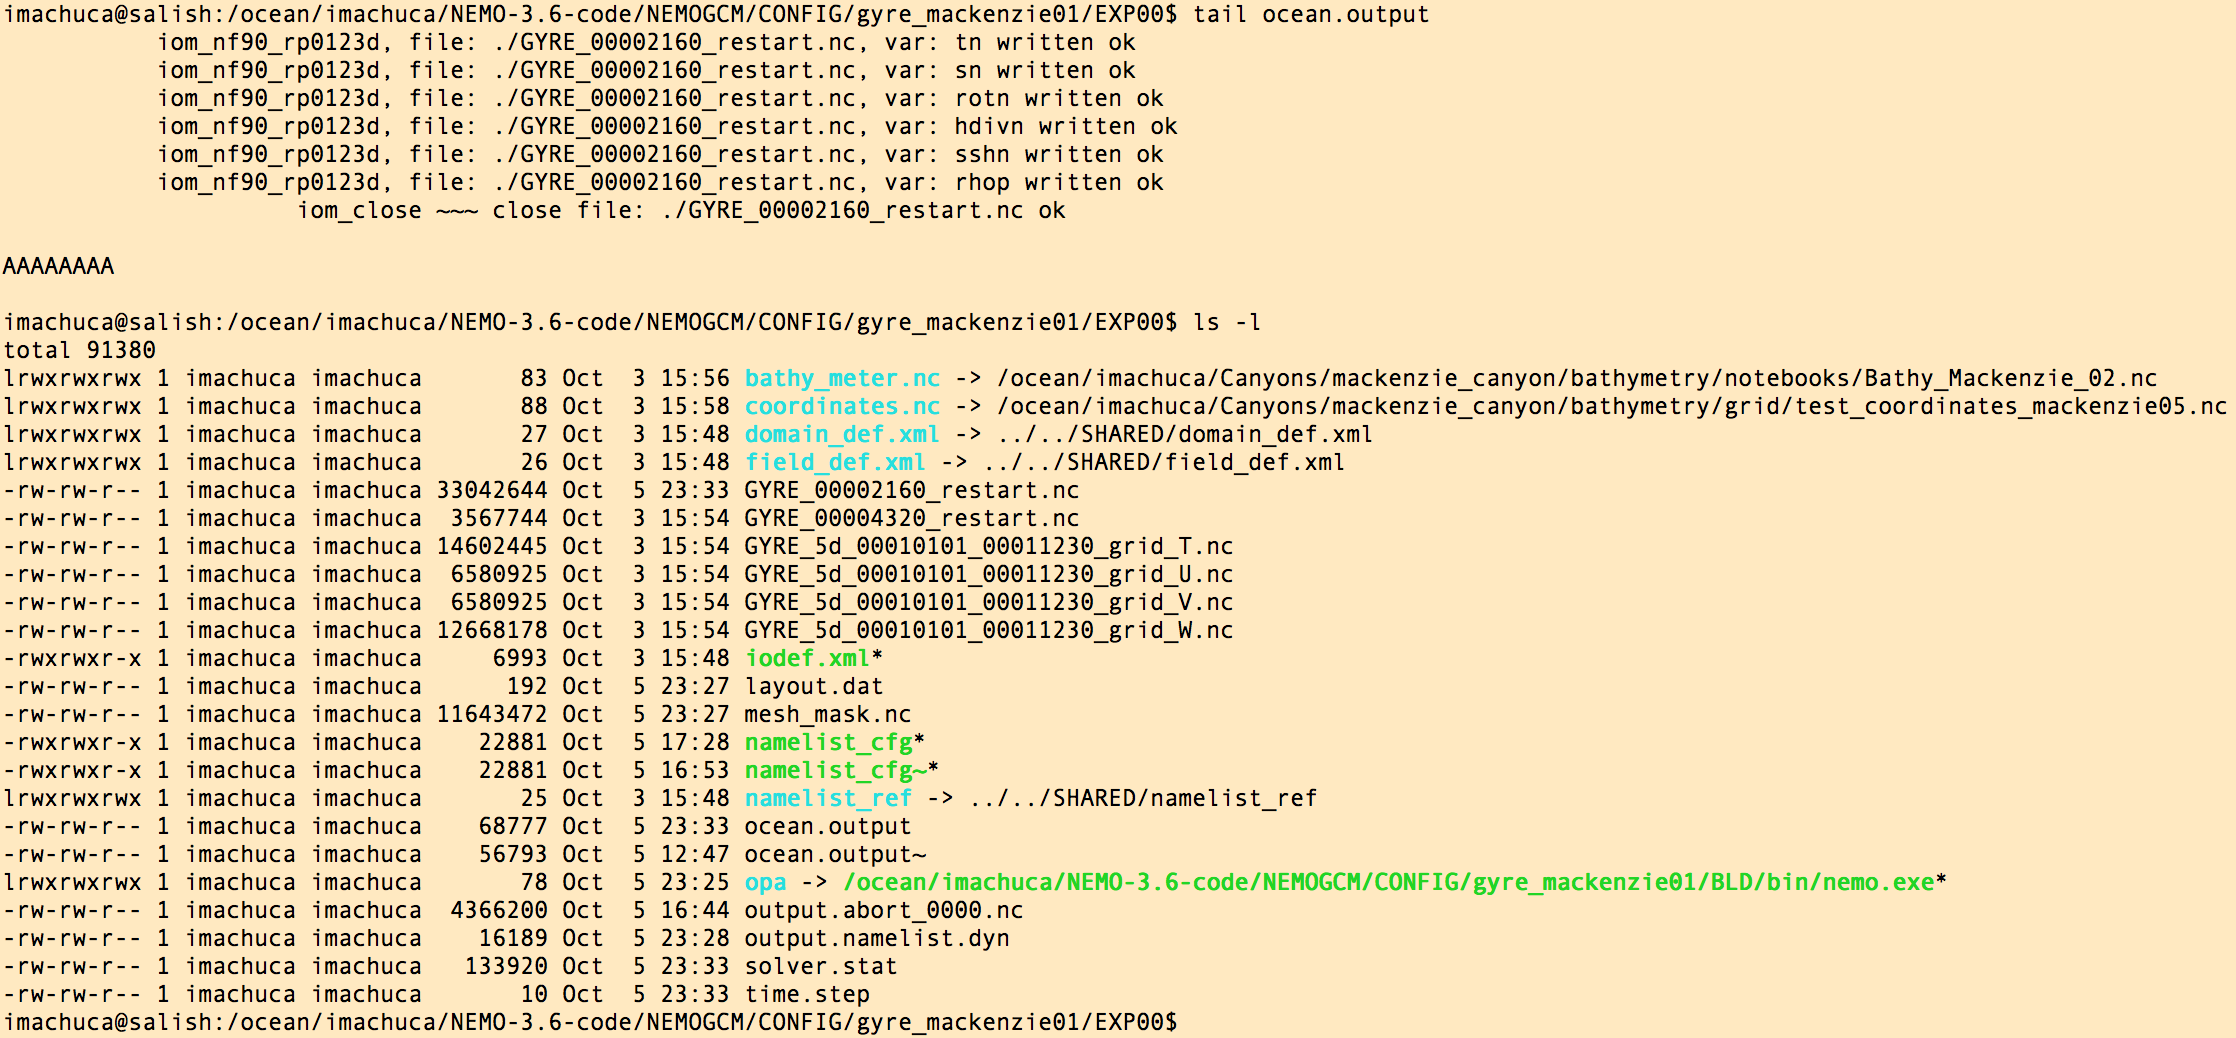

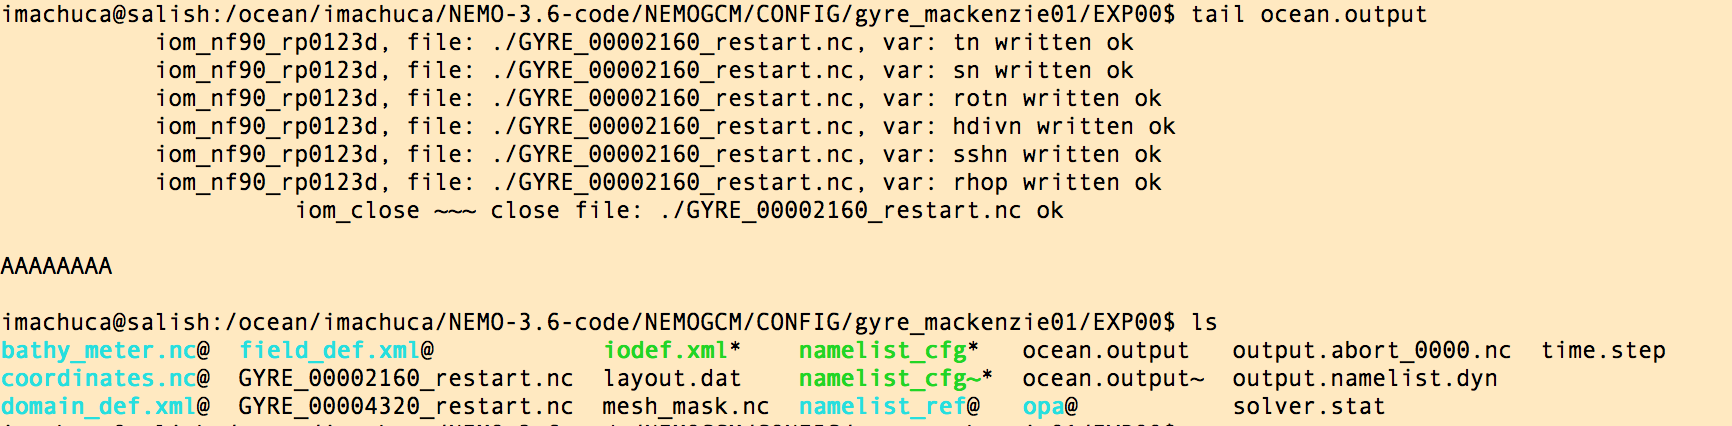

In [40]:
display(Image(filename='../../images/before.png', width=1000))
display(Image(filename='../../images/after.png', width=1000))